In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from sklearn.utils import shuffle
from sklearn import set_config, metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, LeaveOneGroupOut, KFold, GroupKFold, StratifiedGroupKFold

In [3]:
sns.set_context("talk")
sns.set_theme(style='white')
sns.set_style("darkgrid")
sns.set_palette('bright')

In [4]:
df_main_author = pd.read_csv(r'../data/df_awards_authors.csv')
df_main_author.set_index("Unnamed: 0", inplace = True)
df_main_author = df_main_author.replace(np.nan, 0)

In [5]:
df_main_author.AWARD.value_counts()

AWARD
not_awarded    1347
awarded          88
Name: count, dtype: int64

In [6]:
def plot_coefficients(coefs, feature_names, top_features):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    fig, ax = plt.subplots(figsize=(15, 5))

    colors = ['awarded' if c < 0 else 'not_awarded' for c in coefs[top_coefficients]]
    feature_names = np.array(feature_names)
    zipped = list(zip(feature_names, coefs[top_coefficients], colors))
    df_tmp = pd.DataFrame(zipped, columns=['features', 'coefs', 'colors'])
    
    sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())

    ax.set_xlabel('Feature name', fontsize = 30)
    ax.set_ylabel('Coefficient score', fontsize = 30)
    
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    #plt.title("Best classification coefficients")
    plt.savefig('../img/coefs_linear_svm_canon_novels.png', format='png', bbox_inches='tight', dpi=400)

    plt.show()
    


In [25]:
def KF_canonized(df_main, n_splits=5, probas=False, kernel='rbf'):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    ALL_PROBAS, ALL_INDEX = [], [] # lists of all test probas and all test index
    
    pipe = make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=probas, kernel=kernel))#{"canon":10, "non_canon":1}
    kf = KFold(n_splits)
    
    for (train_index, test_index) in kf.split(df_main.drop(['auteur', 'AWARD'], axis=1), df_main['AWARD']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'AWARD'], axis=1)
            y_train = train['AWARD']
            X_test = test.drop(['auteur', 'AWARD'], axis=1)
            y_test = test['AWARD']
            
            pipe.fit(X_train, y_train)               
            preds = pipe.predict(X_test)
            
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)
                        
            if probas==True:
                probs = pipe.predict_proba(X_test)[:,0]
                ALL_PROBAS.extend(probs)

            
    _ = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS)

    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)
    
    if kernel == 'linear':
        coefs = pipe.named_steps['svc'].coef_
        df_coefs = pd.DataFrame(coefs, columns=X_train.columns)
        df_coefs.to_csv("../outputs/coefs_novel_scale.csv")
        plot_coefficients(*coefs, X_train.columns, 20)
        return pipe, df_scores, bas, df_coefs
    
    if probas==True:
        df_results = pd.DataFrame()
        
        df_results['metadata'] = ALL_GT
        df_results['proba_AWARD'] = ALL_PROBAS
        df_results['prediction']= ALL_PREDS
        df_results['index']= ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
        
        return pipe, df_scores, bas, df_results.set_index('index')

    return pipe, df_scores, bas

In [14]:
def GKF_canonized(df_main, n_splits=5, probas=False, kernel='rbf'):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    ALL_PROBAS, ALL_INDEX = [], [] # lists of all test probas and all test index
    
    pipe = make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=probas, kernel=kernel))#{"canon":10, "non_canon":1}
    gkf = GroupKFold(n_splits)
    
    for (train_index, test_index) in gkf.split(df_main.drop(['auteur', 'AWARD'], axis=1), df_main['AWARD'], df_main['auteur']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'AWARD'], axis=1)
            y_train = train['AWARD']
            X_test = test.drop(['auteur', 'AWARD'], axis=1)
            y_test = test['AWARD']
            
            pipe.fit(X_train, y_train)               
            preds = pipe.predict(X_test)
            
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)
                        
            if probas==True:
                probs = pipe.predict_proba(X_test)[:,0]
                ALL_PROBAS.extend(probs)

            
    _ = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS)

    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)
    
    if kernel == 'linear':
        coefs = pipe.named_steps['svc'].coef_
        df_coefs = pd.DataFrame(coefs, columns=X_train.columns)
        df_coefs.to_csv("../outputs/coefs_novel_scale.csv")
        plot_coefficients(*coefs, X_train.columns, 20)
        return pipe, df_scores, bas, df_coefs
    
    if probas==True:
        df_results = pd.DataFrame()
        
        df_results['metadata'] = ALL_GT
        df_results['proba_AWARD'] = ALL_PROBAS
        df_results['prediction']= ALL_PREDS
        df_results['index']= ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
        
        return pipe, df_scores, bas, df_results.set_index('index')

    return pipe, df_scores, bas

In [9]:
def ratio_truncate(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = df_res.AWARD.value_counts(normalize=True).awarded
    index_noncanon = df_res[df_res['AWARD']  == 'not_awarded'].index 
    i, j = 0, 20
    
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=10
        ratio_temp = df_res.AWARD.value_counts(normalize=True).awarded

    return shuffle(df_res)

In [17]:
def N_canonizer_sizeopti(df_main, N_fold=5, N_sample=10, ratio=0.5):
    list_res, all_bas = [], []
    for i in tqdm(range(N_sample)):
        df_sizeopti_last = ratio_truncate(df_main, ratio)
        pipe, results, bas = GKF_canonized(df_sizeopti_last, N_fold)
        list_res.append(results)
        all_bas.append(bas)
    all_results = pd.concat(list_res).groupby(level=0).mean()
    print(sum(all_bas)/len(all_bas))
    return pipe, all_results, all_bas # return last pipe

In [36]:
df_sizeopti = ratio_truncate(df_main_author, 0.5)

0.7541144200626959


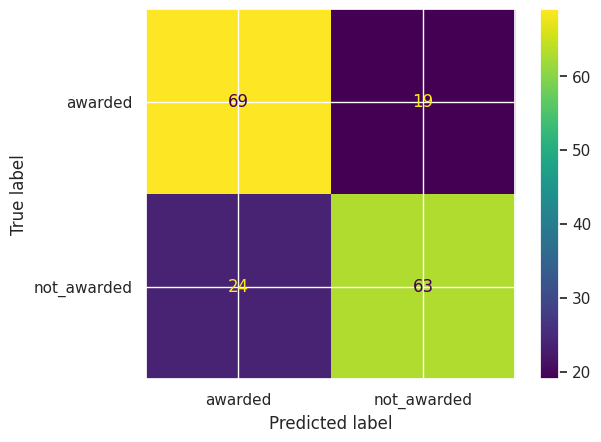

In [37]:
pipe, df_scores, bas, df_results = KF_canonized(df_sizeopti, probas=True)

0.7025862068965517


/tmp/ipykernel_46150/2146443360.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


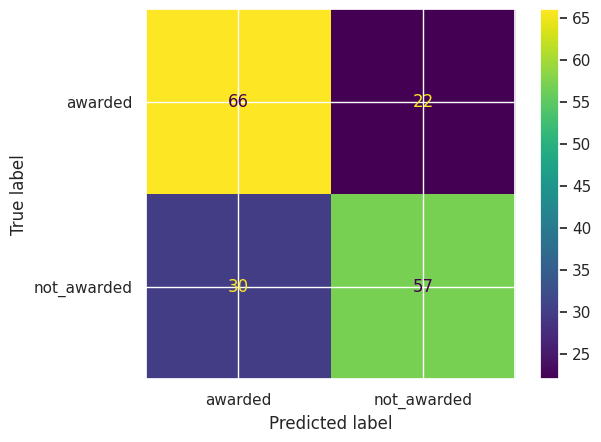

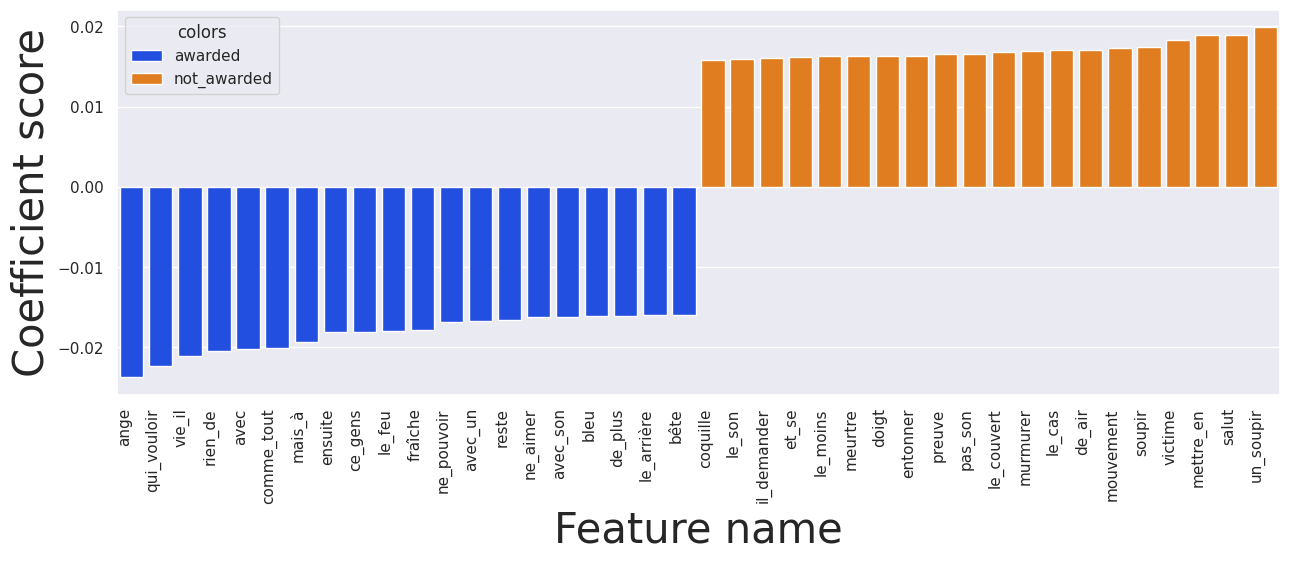

In [38]:
pipe, df_scores, bas, df_results = KF_canonized(df_sizeopti, probas=True, kernel='linear')

In [41]:
df_concat = pd.concat([df_sizeopti.iloc[:, 0:600], df_sizeopti.iloc[:, 1000:1600]],  axis=1)
df_concat['AWARD']=df_sizeopti['AWARD']
df_concat['auteur']=df_sizeopti['auteur']

0.7710292580982236


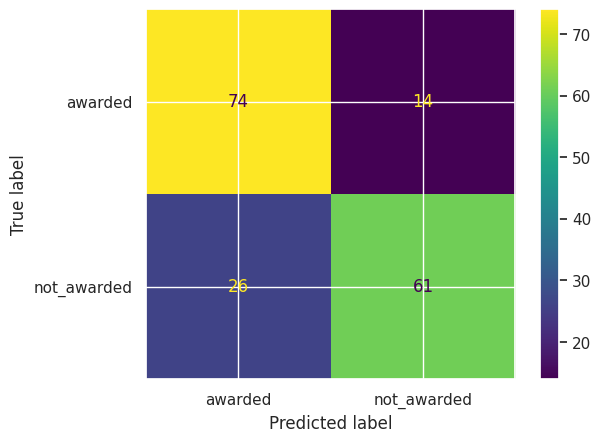

In [42]:
pipe, df_scores, bas = KF_canonized(df_concat)

0.7141457680250785


/tmp/ipykernel_46150/2146443360.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


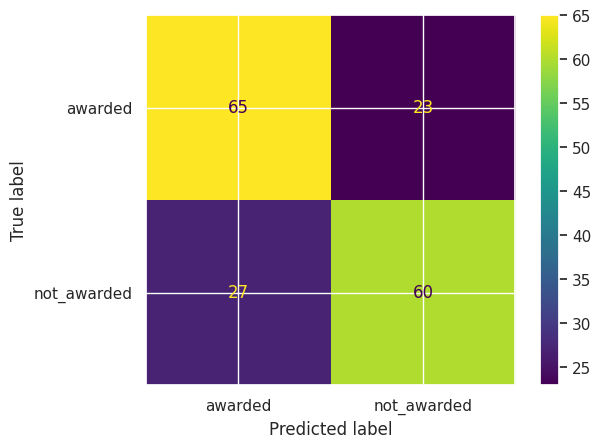

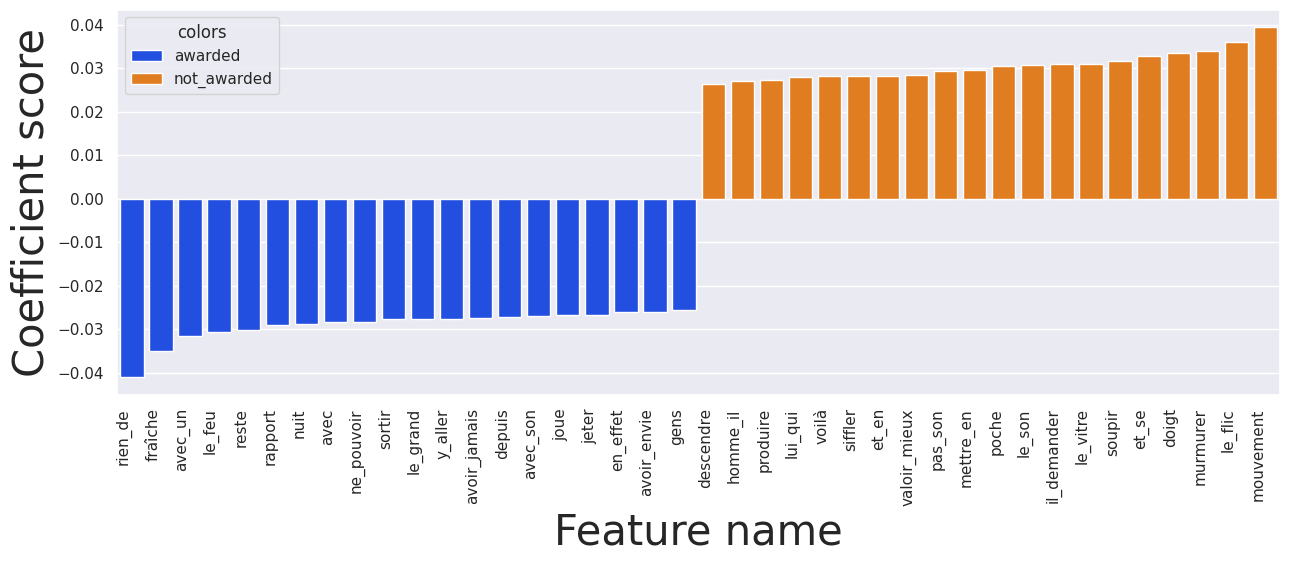

In [44]:
pipe, df_scores, bas, rez = KF_canonized(df_concat, kernel="linear")

# GroupKFold

0.7029780564263323


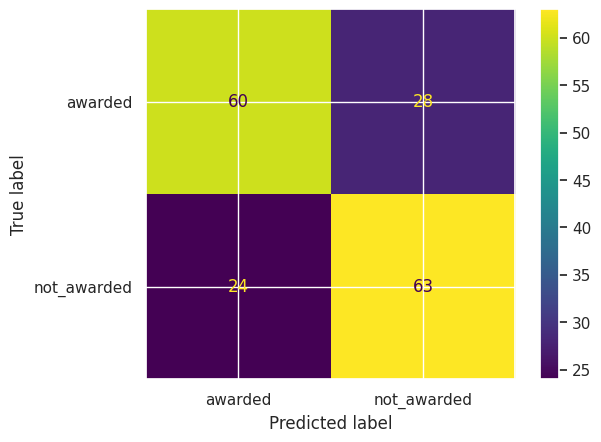

In [23]:
pipe, df_scores, bas, df_results = GKF_canonized(df_sizeopti, probas=True)

0.6741118077324975


/tmp/ipykernel_46150/2146443360.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


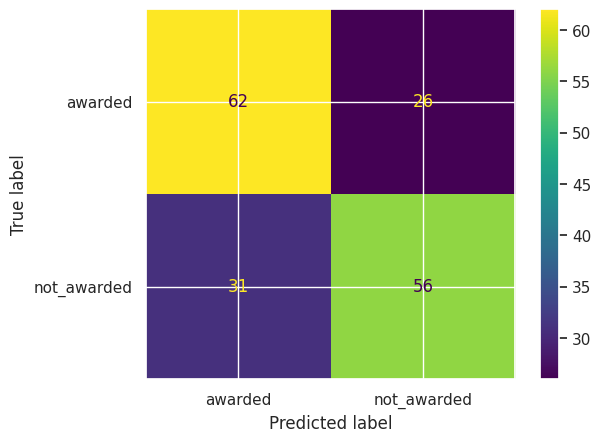

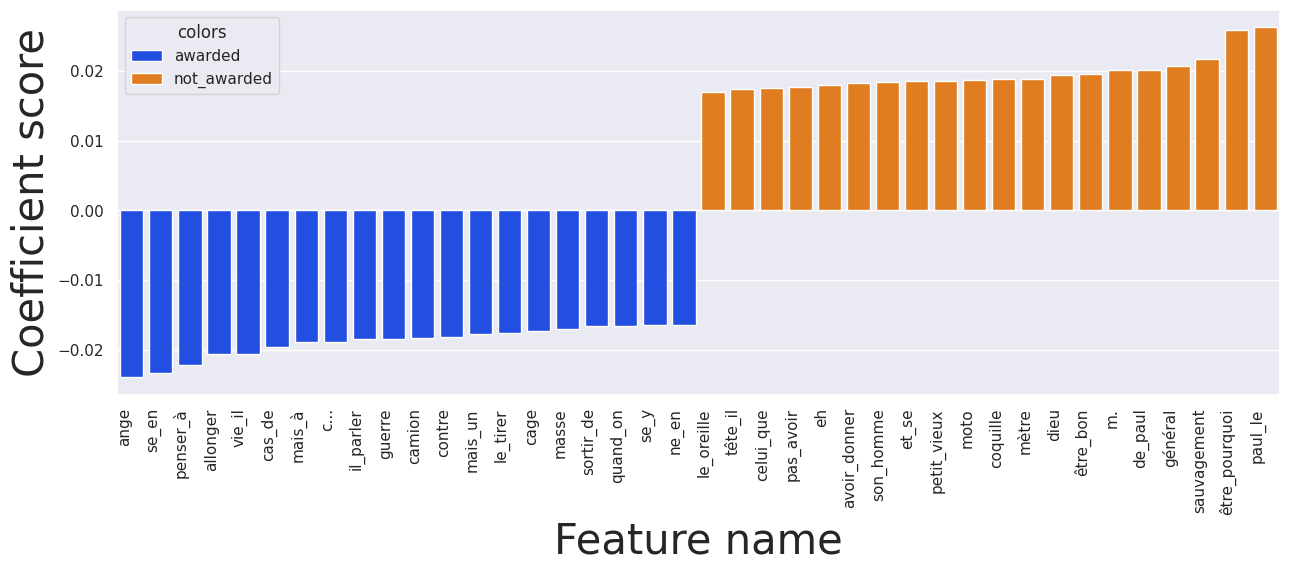

In [24]:
pipe, df_scores, bas, df_results = GKF_canonized(df_sizeopti, probas=True, kernel='linear')